# Bring in Modules

In [372]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import numpy as np

# Bring in Data

In [93]:
cord_19_metadata = pd.read_csv("/Volumes/LaCie/Dispersed Volunteer Research Network/Project 21/Data/2021-03-29/metadata.csv")
fda_biologics = pd.read_csv("/Volumes/LaCie/Dispersed Volunteer Research Network/Project 21/Data/FDA Products List (Last Updated ~September 2020) - Sheet1.csv")
drug_date_df = pd.read_csv("/Users/cpollack/project_21_clinical_trials_during_covid_19_pandemic/cord_19/210403_drug_date_df.csv")

# Functions

In [29]:
def find_drug(abstract, drug, date, cord_uid):
    '''
        Function that will identify whether the drug of interest is in the abstract of interest and, if so, return a formatted dictionary that can be appeneded to a dataframe
        Parameters:
            abstract (str): The abstract of interest (assumed to be all lowercase)
            drug (str): The drug of interest (assumed to be all lowercase)
            date (str): The date that the manuscript was published (will only be used if drug in abstract)"
            cord_uid (str): The unique identifier that we can use to link the abstract back to the CORD-19 metadata file (will only be used if drug in abstract)"
       
       Return:
            dict_return (dict): A dictionary with the drug, date of publication, and cord_uid for the artcile
     '''
    if drug in abstract:
        dict_return = {"drug": drug,
                       "date": date,
                       "cord_uid": cord_uid}
        return dict_return

# Creating Processed List of Biologics

In [15]:
fda_biologics["processed"] = fda_biologics.PRODUCT.str.replace("_", " ")
fda_biologics.processed = fda_biologics.processed.str.lower()
fda_biologics_list = [y for x in fda_biologics.processed.tolist() for y in x.split('/')]

# COVID-19 Related Term

Terms  pulled from NIH MeSH: https://www.ncbi.nlm.nih.gov/mesh/2052179

In [9]:
covid_19_terms = ["COVID 19", "COVID-19", "2019-nCoV", "2019 nCoV", "Coronavirus Disease-19", "Coronavirus Disease 19", 
                  " 2019 Novel Coronavirus", "COVID19", "Coronavirus Disease 2019", "SARS Coronavirus 2 Infection", 
                  "SARS-CoV-2", "SARS CoV 2"]

# Processing Abstract Data

In [10]:
cord_19_metadata["processed_abstract"] = cord_19_metadata.abstract.str.lower()
print(cord_19_metadata.shape) #497,906 rows before
cord_19_metadata = cord_19_metadata[cord_19_metadata.processed_abstract.notna()]
print(cord_19_metadata.shape) #363,064 rows after removing NaN abstracts"

(497906, 20)
(363064, 20)


# Creating COVID-Specific Data

In [11]:
cord_19_covid = cord_19_metadata[cord_19_metadata["processed_abstract"].str.contains('|'.join([x.lower() for x in covid_19_terms]))]
print(cord_19_covid.shape) #198,494 when only keeping those that directly mention COVID-19"

(198494, 20)


# Filtering to Only Include Biologics of Interest

In [17]:
cord_19_covid_fda = cord_19_covid[cord_19_covid["processed_abstract"].str.contains('|'.join(fda_biologics_list))]
print(cord_19_covid_fda.shape) #12,719 when only keeping those that directly mention COVID-19 and one of the biologics
cord_19_covid_fda = cord_19_covid_fda.reset_index(drop = True)

(12719, 20)


# Creating new drug-specific dataframe

In [31]:
drug_date_df = pd.DataFrame()

for row in range(0, len(cord_19_covid_fda)):
    if row % 1000 == 0:
        print(row)
    for drug in fda_biologics_list:
        row_to_append = find_drug(cord_19_covid_fda.processed_abstract[row], 
                                  drug, 
                                  cord_19_covid_fda.publish_time[row], 
                                  cord_19_covid_fda.cord_uid[row])
        
        drug_date_df = drug_date_df.append(row_to_append, ignore_index = True)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


# Processing drug_date_df (can start here since output is saved)

## Converting date column into date

In [209]:
#23,848 rows
len(drug_date_df)
drug_date_df["date_date"] = pd.to_datetime(drug_date_df["date"], format = "%Y-%m-%d")

## Creating new dataframe that doesn't include hydroxychloroquine (may be duplicated)

In [210]:
drug_date_df_no_hydroxy = drug_date_df.loc[drug_date_df["drug"] != "hydroxychloroquine"] 
drug_date_df_no_hydroxy.shape
#23,848 rows to #19,824 rows

(19824, 5)

## Remove rows that don't have a date or the date is only the year

In [211]:
drug_date_df_no_hydroxy = drug_date_df_no_hydroxy[(drug_date_df_no_hydroxy.date != "2019") & 
                                                  (drug_date_df_no_hydroxy.date != "2020") & 
                                                  (drug_date_df_no_hydroxy.date != "2021")&
                                                  (drug_date_df_no_hydroxy.date.notnull())]
drug_date_df_no_hydroxy #9,304 rows

,Unnamed: 0,cord_uid,date,drug,date_date
0,0,puc13jf1,2020-04-01,remdesivir,2020-04-01
1,1,418c14nv,2020-01-27,remdesivir,2020-01-27
2,2,qp2z14xs,2020-02-21,lopinavir,2020-02-21
3,3,gf7ya2bd,2020-04-08,remdesivir,2020-04-08
4,4,gf7ya2bd,2020-04-08,chloroquine,2020-04-08
...,...,...,...,...,...
23842,23842,p88auycu,2020-08-12,chloroquine,2020-08-12
23844,23844,p88auycu,2020-08-12,antibiotics,2020-08-12
23845,23845,gpr86lxe,2020-04-05,remdesivir,2020-04-05
23846,23846,8art2tyj,2020-08-06,remdesivir,2020-08-06


# Visualization Over time

## Preprocessing for generic date vs. drug

In [214]:
drug_date_df_no_hydroxy = drug_date_df_no_hydroxy.sort_values(by = "date_date")
date_count = drug_date_df_no_hydroxy.groupby(["date_date"]).agg(func = "count")
date_count = date_count.reset_index()
date_count = date_count[date_count["date_date"] <= "2021-03-29"]
date_count

,date_date,Unnamed: 0,cord_uid,date,drug
0,2019-12-31,4,4,4,4
1,2020-01-06,1,1,1,1
2,2020-01-27,2,2,2,2
3,2020-01-28,3,3,3,3
4,2020-01-29,2,2,2,2
...,...,...,...,...,...
403,2021-03-23,12,12,12,12
404,2021-03-24,26,26,26,26
405,2021-03-25,18,18,18,18
406,2021-03-26,20,20,20,20


## Actual Visualization

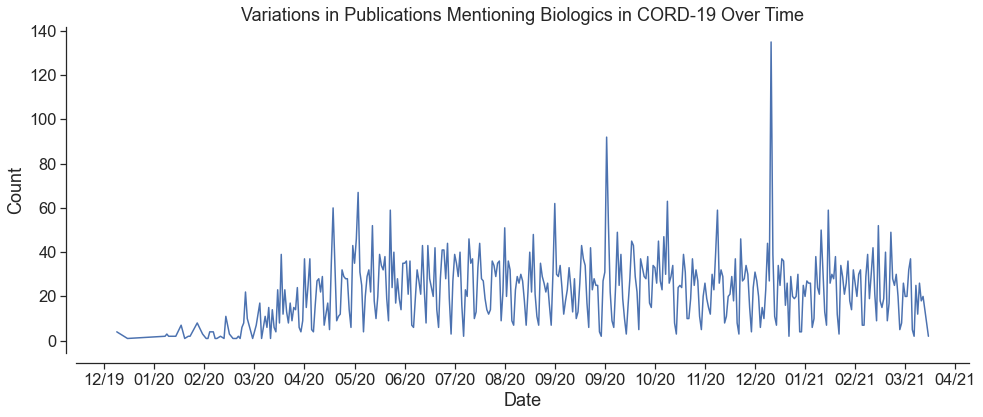

In [273]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.set_style("ticks")
plot = sns.lineplot(data = date_count,
             x = "date_date",
             y = "drug")
sns.despine(offset = 10)
ax.set(xlabel="Date", 
       ylabel="Count",
       title="Variations in Publications Mentioning Biologics in CORD-19 Over Time")
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
ax.xaxis.set_major_formatter(DateFormatter("%m/%y"))
ax.figure.savefig("210403_drug_time.tiff")

# Drug-Specific Visualization Over Time

## Preprocessing

In [283]:
drug_date_count = drug_date_df_no_hydroxy.groupby(["date_date", "drug"]).agg(func = "count")
drug_date_count = drug_date_count.reset_index()
drug_date_count = drug_date_count[drug_date_count["date_date"] <= "2021-03-29"]
drug_date_count

,date_date,drug,Unnamed: 0,cord_uid,date
0,2019-12-31,chloroquine,1,1,1
1,2019-12-31,remdesivir,1,1,1
2,2019-12-31,sarilumab,1,1,1
3,2019-12-31,tocilizumab,1,1,1
4,2020-01-06,remdesivir,1,1,1
...,...,...,...,...,...
3369,2021-03-26,interferon,3,3,3
3370,2021-03-26,remdesivir,2,2,2
3371,2021-03-26,tocilizumab,3,3,3
3372,2021-03-29,antibiotics,1,1,1


## Plotting

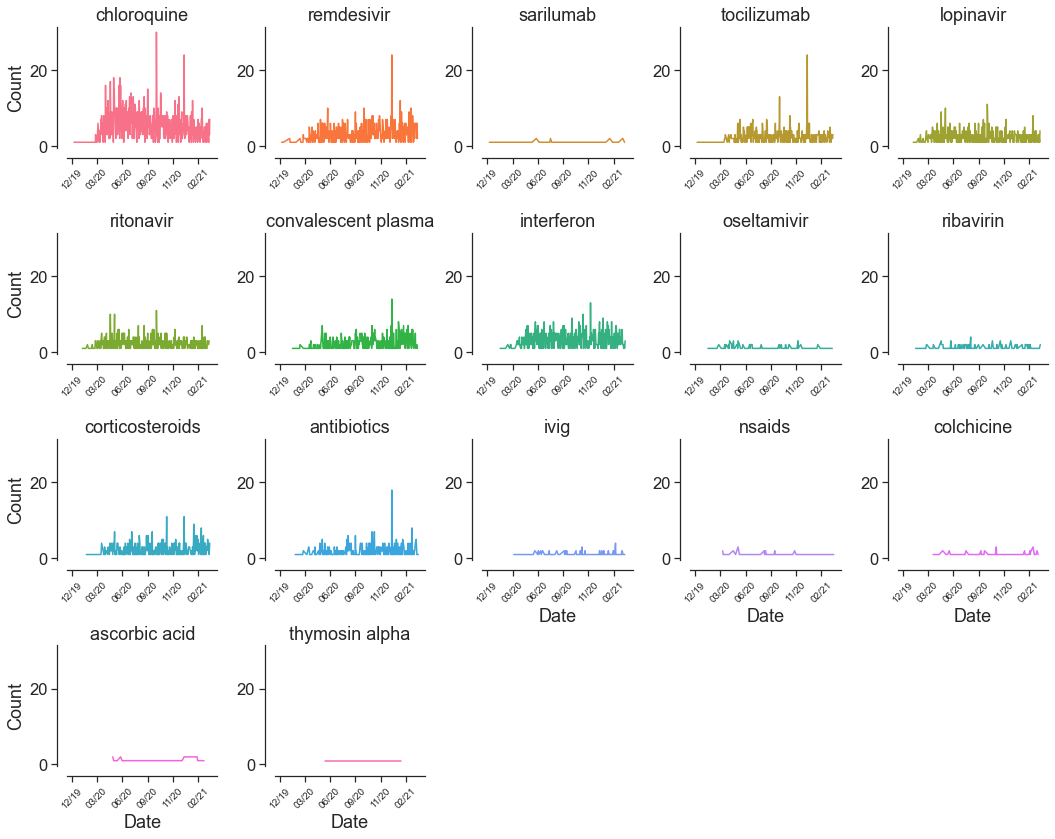

In [270]:
sns.set_style("ticks")
plot = sns.FacetGrid(drug_date_count,
                    col = "drug",
                    hue = "drug",
                    col_wrap = 5)
plot.map_dataframe(sns.lineplot, 
         x = "date_date", 
         y = "date")
sns.despine(offset = 10)

axes = plot.axes.flatten()
for ax in axes:
    ax.set_xlabel("Date")
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=12))
    ax.xaxis.set_major_formatter(DateFormatter("%m/%y"))
    ax.tick_params(axis = "x",
                   labelsize = 10,
                   rotation = 45)
    ax.set_ylabel("Count")
plot.tight_layout()
plot.set_titles(col_template = "{col_name}")
#ax.set(xlabel="Date", 
#       ylabel="Count",
#       title="Variations in Publications Mentioning Biologics in CORD-19 Over Time")
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
#ax.xaxis.set_major_formatter(DateFormatter("%m/%y"))
plot.savefig("210403_drug_facet.tiff")

# Exporting counts of each drug over time

In [284]:
drug_date_count = drug_date_count.drop(["Unnamed: 0", "cord_uid"], axis = 1)
drug_date_count.columns = ["date", "drug", "count"]

In [302]:
drug_date_count_no_hydroxy = drug_date_count.merge(drug_date_df_no_hydroxy,
                                                   left_on = ["date", "drug"],
                                                   right_on = ["date_date", "drug"])
drug_date_count_no_hydroxy = drug_date_count_no_hydroxy.drop(["Unnamed: 0", "date_y", "date_date"], axis = 1)
drug_date_count_no_hydroxy.columns = ["date", "drug", "count", "cord_uid"]

In [305]:
drug_date_count_no_hydroxy.to_csv("210403_drug_date_count_no_hydroxy.csv")

# Preprints vs. Prints

## Generate Preprint List

In [331]:
journal_list = cord_19_covid_fda.journal.unique().tolist()
journal_list = [str(x).lower() for x in journal_list]
preprint_list = [j for j in journal_list if "rxiv" in j]

## Only keep those that have a journal

In [ ]:
cord_19_covid_fda_journal = cord_19_covid_fda[cord_19_covid_fda.journal.notna()]
cord_19_covid_fda_journal.shape #11,667

## Adding Flag

In [348]:
cord_19_covid_fda_journal["journal_processed"] = cord_19_covid_fda_journal.journal.str.lower()
cord_19_covid_fda_journal["preprint_indicator"] = cord_19_covid_fda.journal_processed.isin(preprint_list).astype(int)

/Users/cpollack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/cpollack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Preprocessing for Visualization

In [352]:
cord_19_covid_fda_journal_flag = cord_19_covid_fda_journal[["cord_uid", "preprint_indicator"]]

## Redoing Visualizations

### Preprocessing for Generic Over Time

In [359]:
drug_date_df_no_hydroxy_preprint = drug_date_df_no_hydroxy.merge(cord_19_covid_fda_journal_flag,
                                                                how = "left")
date_count_preprint = drug_date_df_no_hydroxy_preprint.groupby(["date_date", "preprint_indicator"]).agg(func = "count")
date_count_preprint = date_count_preprint.reset_index()
date_count_preprint = date_count_preprint[date_count_preprint["date_date"] <= "2021-03-29"]
date_count_preprint

,date_date,preprint_indicator,Unnamed: 0,cord_uid,date,drug
0,2019-12-31,0.0,8,8,8,8
1,2020-01-06,1.0,1,1,1,1
2,2020-01-27,1.0,2,2,2,2
3,2020-01-28,0.0,3,3,3,3
4,2020-01-29,1.0,2,2,2,2
...,...,...,...,...,...,...
635,2021-03-23,0.0,11,11,11,11
636,2021-03-24,0.0,25,25,25,25
637,2021-03-25,0.0,16,16,16,16
638,2021-03-26,0.0,5,5,5,5


### Visualization

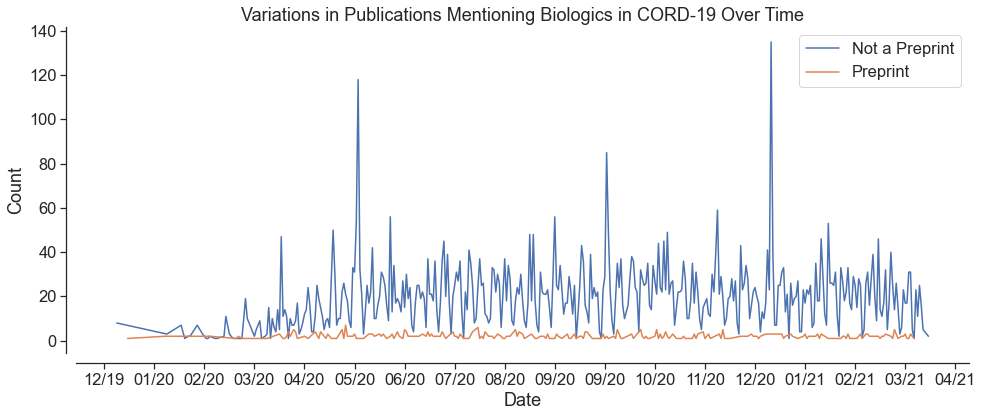

In [364]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.set_style("ticks")
plot = sns.lineplot(data = date_count_preprint,
                    x = "date_date",
                    y = "drug",
                   hue = "preprint_indicator")
sns.despine(offset = 10)
ax.set(xlabel="Date", 
       ylabel="Count",
       title="Variations in Publications Mentioning Biologics in CORD-19 Over Time")
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
ax.xaxis.set_major_formatter(DateFormatter("%m/%y"))
ax.legend(labels=["Not a Preprint", "Preprint"])
#ax.figure.savefig("210403_drug_time_preprint.tiff")

### Preprocessing for Drug-Specific Over Time

In [365]:
drug_date_count_preprint = drug_date_df_no_hydroxy_preprint.groupby(["date_date", "preprint_indicator", "drug"]).agg(func = "count")
drug_date_count_preprint = drug_date_count_preprint.reset_index()
drug_date_count_preprint = drug_date_count_preprint[drug_date_count_preprint["date_date"] <= "2021-03-29"]
drug_date_count_preprint

,date_date,preprint_indicator,drug,Unnamed: 0,cord_uid,date
0,2019-12-31,0.0,chloroquine,2,2,2
1,2019-12-31,0.0,remdesivir,2,2,2
2,2019-12-31,0.0,sarilumab,2,2,2
3,2019-12-31,0.0,tocilizumab,2,2,2
4,2020-01-06,1.0,remdesivir,1,1,1
...,...,...,...,...,...,...
3542,2021-03-26,0.0,chloroquine,2,2,2
3543,2021-03-26,0.0,corticosteroids,2,2,2
3544,2021-03-26,0.0,tocilizumab,1,1,1
3545,2021-03-29,0.0,antibiotics,1,1,1


### Visualization

/Users/cpollack/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


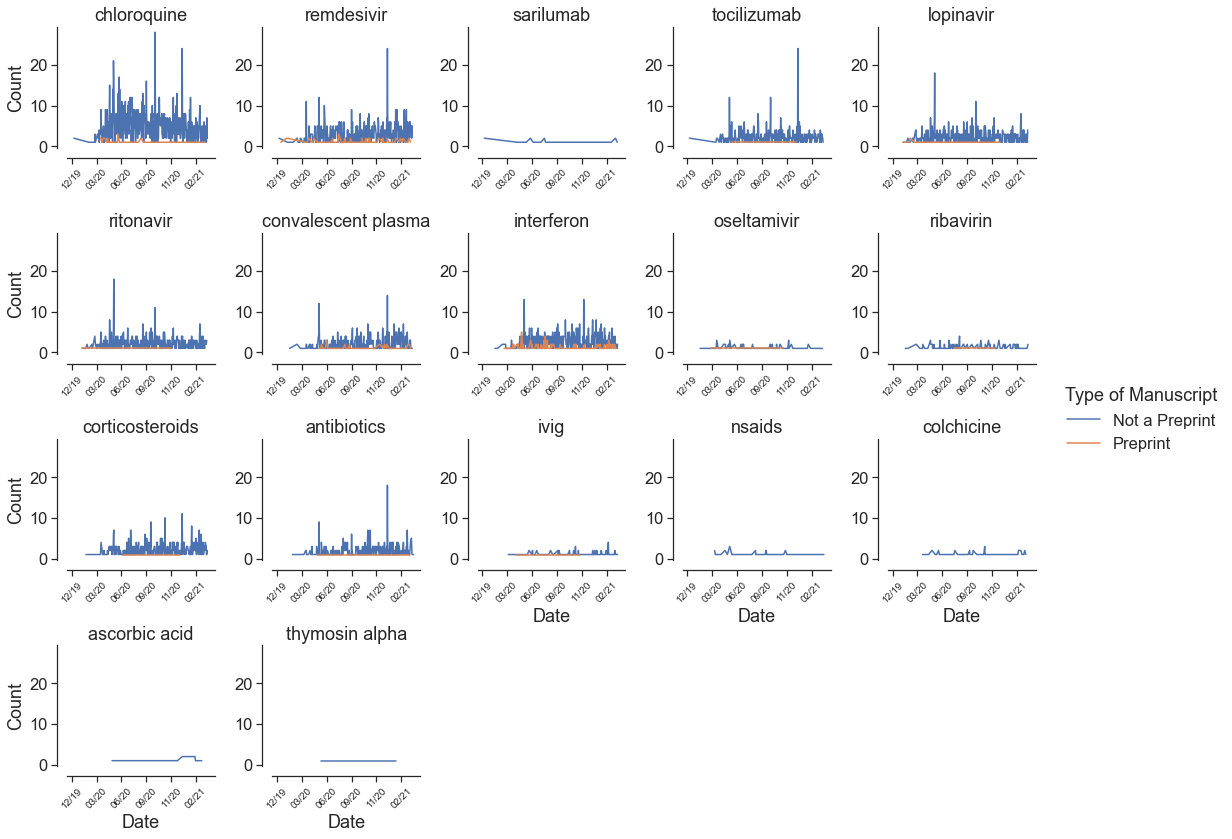

In [382]:
sns.set_style("ticks")
plot = sns.FacetGrid(drug_date_count_preprint,
                    col = "drug",
                    hue = "preprint_indicator",
                    col_wrap = 5)
plot.map_dataframe(sns.lineplot, 
         x = "date_date", 
         y = "date").add_legend(title = "Type of Manuscript",
                                labels=["Not a Preprint", "Preprint"])
sns.despine(offset = 10)
axes = plot.axes.flatten()
for ax in axes:
    ax.set_xlabel("Date")
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=12))
    ax.xaxis.set_major_formatter(DateFormatter("%m/%y"))
    ax.tick_params(axis = "x",
                   labelsize = 10,
                   rotation = 45)
    ax.set_ylabel("Count")
plot.tight_layout()
plot.set_titles(col_template = "{col_name}")


#ax.set(xlabel="Date", 
#       ylabel="Count",
#       title="Variations in Publications Mentioning Biologics in CORD-19 Over Time")
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
#ax.xaxis.set_major_formatter(DateFormatter("%m/%y"))
plot.savefig("210403_drug_facet_preprint.tiff")